### Carregando as bibliotecas

In [2]:
import re
import time
import nltk
import math
import spacy
import pickle
import random
import pandas as pd
import statistics as st
import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from langdetect import detect
from pymongo import MongoClient
from textblob import TextBlob
from nltk.tag import pos_tag
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [2]:
# Download nltk packages
nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tatsuya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tatsuya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Carregando os dados

In [12]:
collections = [('raw_CNN', 'portuguese', 0), ('raw_Estadao', 'portuguese', 0), ('raw_FatoFake', 'portuguese', 1), 
               ('raw_G1', 'portuguese', 0), ('raw_MinisterioFake', 'portuguese', 1),
               ('raw_SanarmedFake', 'portuguese', 1), ('raw_UOL', 'portuguese', 0), ('raw_Kaggle', 'english', None)]

# Load all collections data from MongoDB
db = MongoClient()
raw_data = pd.DataFrame()
for c in collections:
    collection = db['covid-fake-news-detection'][c[0]]
    data_collection = pd.DataFrame(list(collection.find()))
    data_collection['language'] = c[1]
    if c[2] is not None:
        data_collection['label'] = c[2]
    else:
        data_collection['label'] = data_collection['label'].apply(lambda x: 1 if x == 'fake' else 0)
    data_collection['origin'] = c[0].replace('raw_','')
    raw_data = pd.concat([raw_data, data_collection]).reset_index(drop=True)
    
raw_data['title'] = raw_data['title'].apply(lambda f: f.replace("'", "").replace('"', '').replace('\n', ''))
raw_data['datetime'] = pd.to_datetime(raw_data['datetime']).apply(lambda x: x.date())
raw_data['datetime'] = raw_data['datetime'].apply(lambda d: d.strftime("%d/%m/%Y") if d is not pd.NaT else d)

del raw_data['link']

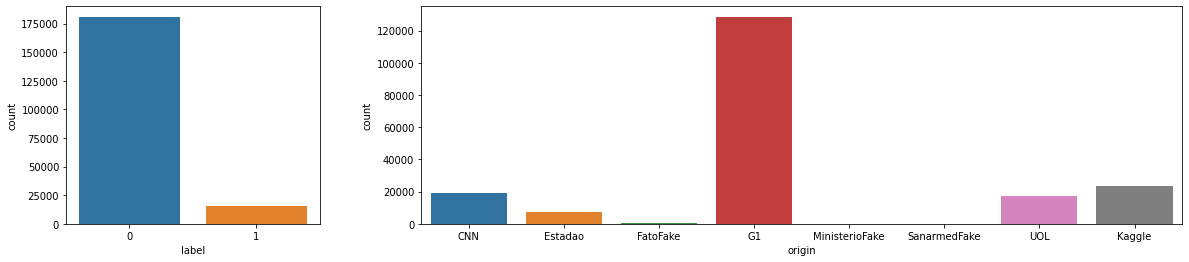

In [3]:
# Set grid of 2 columns
fig, (a0, a1) = plt.subplots(ncols=2, gridspec_kw = {'width_ratios':[1, 3]})
fig.set_figwidth(20)
# Show count for positive for fake news (1) and negative for fake news (0)
sns.countplot(x="label", data=raw_data, ax=a0)
# Show count for every origin
sns.countplot(x="origin", data=raw_data, ax=a1)
plt.show()

### Reamostragem: Undersampling induzido

É verdade que temos muito mais amostras negativas para fake news (label = 0) e muito mais amostras provenientes da fonte G1. Nesta fase da reamostragem, será performado um undersampling induzido, com o objetivo de remover amostras negativas para fake news que provavelmente não ofereçam conteúdo relevante para a análise (de todas as fontes dinâmicas) e remover aleatoriamente amostras da fonte G1, para balancear também a proveniência dos dados.

In [13]:
# Locate and remove samples from all dynamic fonts which do not contain some particular substrings
pattern = '(?i)covid|corona|vacina|mascara|máscara'
out_of_context = raw_data[(raw_data['language'] == 'portuguese') & (raw_data['label'] == 0)]
out_of_context = out_of_context[~out_of_context['title'].str.contains(pattern)]
raw_data = raw_data.drop(list(out_of_context.index))

In [14]:
# Locate and remove samples from all dynamic fonts with 2 or more numbers (high probably only reports number of cases/deaths)
only_reports = raw_data[(raw_data['language'] == 'portuguese') & (raw_data['label'] == 0)]
only_reports = only_reports[only_reports.apply(lambda x: len(re.findall(r'\b\d+\b', x['title'])) >= 2, axis=1)]
raw_data = raw_data.drop(list(only_reports.index))

In [15]:
# Locate and remove samples from all dynamic fonts which contain custom substrings
pattern = '(?i)veja lista com perfil|casos de coronavírus na|casos de coronavírus em'
custom_substring = raw_data[(raw_data['language'] == 'portuguese') & (raw_data['label'] == 0)]
custom_substring = custom_substring[custom_substring['title'].str.contains(pattern)]
raw_data = raw_data.drop(list(custom_substring.index))

In [16]:
# Remove duplicated samples from all fonts
raw_data = raw_data.drop_duplicates(subset='title', keep="last")

In [17]:
# Remove random samples from G1, leaving n samples left, where n is the mean number of samples of other fonts
n_med_cat = int(raw_data.groupby(['origin'])['_id'].count().drop('G1').mean())
g1_raw_data = raw_data[raw_data['origin'] == 'G1']
g1_raw_data = g1_raw_data.sample(n = g1_raw_data.shape[0] - n_med_cat, random_state=1)
raw_data = raw_data.drop(list(g1_raw_data.index))

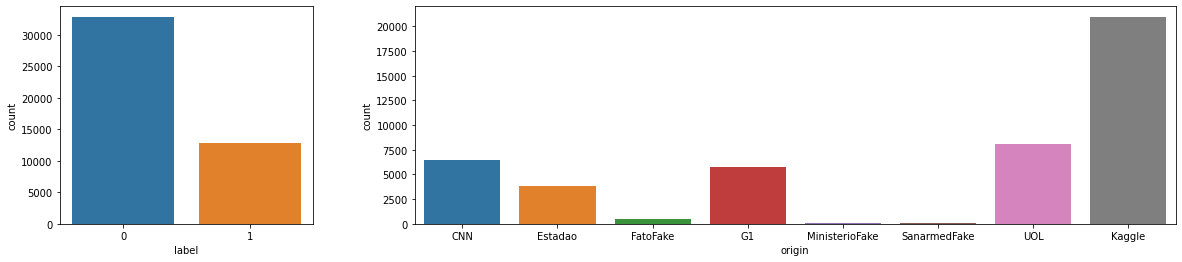

In [18]:
# Set grid of 2 columns
fig, (a0, a1) = plt.subplots(ncols=2, gridspec_kw = {'width_ratios':[1, 3]})
fig.set_figwidth(20)
# Show count for positive for fake news (1) and negative for fake news (0)
sns.countplot(x="label", data=raw_data, ax=a0)
# Show count for every origin
sns.countplot(x="origin", data=raw_data, ax=a1)
plt.show()

### Tradução das amostras em português para inglês

In [34]:
# Batch export 3k of phrases to external translate
pt_raw_data = raw_data[raw_data['language'] == 'portuguese']
with open('your_file.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(list(pt_raw_data['title'])[:3000]))

In [35]:
# Batch load 3k of phrases after exteral translate into dataframe object
with open('your_file.txt', 'r', encoding="utf-8") as f:
    lines = f.readlines()
lines = list(map(lambda x: x.replace('\n','').replace('  ', ' '), lines))
ids = list(pt_raw_data[:3000].index)
for i in range(3000):
    raw_data.at[ids[i], 'title'] = lines[i]
    raw_data.at[ids[i], 'language'] = 'english'

In [36]:
# Save pickle file with translated dataframe
with open(r'pickles\translated.pickle', 'wb') as f:
    pickle.dump(raw_data, f)

In [13]:
# Load pickle file with translated dataframe
with open(r'pickles\translated.pickle', 'rb') as f:
    raw_data = pickle.load(f)

In [14]:
t_data = raw_data.copy()

### Remoção de ruído, correção de escrita e lowerização (caixa baixa)

In [15]:
# Remove non-ASCII characters from Kaggle databases (for tweet cleaning)
def remove_non_ASCII(title, origin):
    if origin == 'Kaggle':
        title = title.encode("ascii", "ignore").decode()
    return title
t_data['title'] = t_data.apply(lambda x: remove_non_ASCII(x['title'], x['origin']), axis=1)

In [16]:
# Remove Twitter hashtags and citations from Kaggle databases
def remove_hashtags_citations(title, origin):
    if origin == 'Kaggle':
        title = ' '.join([t for t in title.split(' ') if not t.startswith('#') and not t.startswith('@') and not t.startswith('https:')])
    return title
t_data['title'] = t_data.apply(lambda x: remove_hashtags_citations(x['title'], x['origin']), axis=1)

In [17]:
# Remove ponctuation from all samples
def remove_ponct(title):
    ponct = ['.', ',', ';', ':', '!', '?', "\\", "/", "_", "-", '~']
    for p in ponct:
        title = title.replace(p, '')
    return title.strip()
t_data['title'] = t_data['title'].apply(lambda x: remove_ponct(x))

In [18]:
# Neutralize accents from all samples
t_data['title'] = t_data['title'].apply(lambda x: unidecode.unidecode(x))

In [21]:
# Spelling correction for Kaggle databases (for tweet cleaning)
def correct_spelling(title, origin):
    if origin == 'Kaggle':
        title = TextBlob(title)
        title = str(title.correct())
    return title
t_data['title'] = t_data.progress_apply(lambda x: correct_spelling(x['title'], x['origin']), axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 45746/45746 [4:12:08<00:00,  3.02it/s]


In [9]:
spell = SpellChecker()
# Lowerize words which are not proper name
def lowerize(title):
    # Get words
    words = [w for w in title.split(' ') if w]
    # Get unknown words (possibly proper names, after correction)
    unknown_words = spell.unknown(words)
    # Get proper names 
    tagged_sent = pos_tag(words)
    propernouns = [word for word,pos in tagged_sent if pos == 'NNP']
    # Lowerize if not identified as proper name and not identified as unknown word
    title = ' '.join([w.lower() if (w not in propernouns) and (w.lower() not in unknown_words) else w for w in words])
    return title
t_data['title'] = t_data['title'].progress_apply(lambda x: lowerize(x))

100%|███████████████████████████████████████████████████████████████████████████| 45746/45746 [00:50<00:00, 905.85it/s]


In [12]:
# Save pickle file with corrected dataframe
with open(r'pickles\corrected.pickle', 'wb') as f:
    pickle.dump(t_data, f)

In [ ]:
# Load pickle file with corrected dataframe
with open(r'pickles\corrected.pickle', 'rb') as f:
    t_data = pickle.load(f)

### Tokenização, remoção de stop words e lematização

In [10]:
data = t_data.copy()

In [76]:
scy = spacy.load("en_core_web_sm")
nltk_sw = nltk.corpus.stopwords.words('english')
def tokenize_pipeline(title):
    title = scy(title)
    # Tokenize
    token_list = [token for token in title]
    # Remove Stop Words
    token_list = [t for t in token_list if str(t) not in nltk_sw]
    # Lemmatize
    lemma_list = [t.lemma_ for t in title]
    # Remove Stop Words (reforce) + custom stop words (like keywords)
    custom_sw = []
    lemma_list = [l for l in lemma_list if l.lower() not in nltk_sw + custom_sw]
    # Remove lemmas which are digits
    lemma_list = [l for l in lemma_list if not l.isdigit()]
    return ' '.join(lemma_list) # Returns joined text to fit TfIdf vectorizer corpus
data['title'] = data['title'].progress_apply(lambda x: tokenize_pipeline(x))

In [14]:
# Save pickle file with tokenized dataframe
with open(r'pickles\tokenized.pickle', 'wb') as f:
    pickle.dump(data, f)

In [3]:
# Load pickle file with tokenized dataframe
with open(r'pickles\tokenized.pickle', 'rb') as f:
    data = pickle.load(f)

### Reamostragem: Oversampling com Data Augmentation

Como ainda existe considerável desbalanceamento das classes e das fontes, será performada uma reamostragem utilizando técnicas de Data Augmentation, com intuito de aumentar o número de amostras positivas para fake news.

In [69]:
# Determinate number of positive samples to sintetize
def ov(N,n,t=0.05):
    if abs(N - n)/(N + n) <= t:
        return math.floor(n)
    return ov(N, n*(1+2*t), t)

n_pos = len(data[data['label'] == 1])
n_neg = len(data[data['label'] == 0])
balanced_pos = ov(n_neg, n_pos, 0.05) # Tolerance of 5%
n_sint = balanced_pos - n_pos

In [70]:
data_positive = data[data['label'] == 1]

# Shuffle words (1/8 of data to sintetize) :: 1/8
def shuffle_string(s):
    s = s.split(' ')
    s = [t for t in s if t]
    return ' '.join(random.sample(s, len(s)))

random_sample = data_positive.sample(n = int(n_sint/12), random_state=10)
random_sample['title'] = random_sample['title'].apply(lambda x: shuffle_string(x))
sintetized_data = random_sample.copy()

In [71]:
# Combine 2 samples (1/8 of data to sintetize) :: 2/8
mean_combine = False # False -> combines all words, True -> get mean number of words
for i in range(int(n_sint/8)):
    random_sample = data_positive.sample(n = 2, random_state=i)
    generated_text = list(random_sample['title'])
    mean_length = int(st.mean([len(generated_text[0]), len(generated_text[1])]))
    generated_text = list(set(generated_text[0].split(' ') + generated_text[1].split(' ')))
    if mean_combine:
        generated_text = random.sample(generated_text, mean_length)
        mean_combine = !mean_combine
    generated_text = ' '.join(generated_text)
    generated_sample = random_sample.iloc[0]
    generated_sample['title'] = generated_text
    sintetized_data = sintetized_data.append(generated_sample, ignore_index=True)

<ipython-input-71-292b23bf3a45>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_sample['title'] = generated_text


In [72]:
# Translate and retranslate (1/2 of data to sintetize) :: 6/8
# Batch export to external translate
random_samples = []
for i in range(7):
    rs = data_positive.sample(n = int(n_sint/14), random_state=20 + i*10).reset_index()
    random_samples.append(rs)
    #with open(f'to_translate_{i}.txt', 'w', encoding="utf-8") as f:
    #    f.write('\n'.join(list(rs['title'])))

In [73]:
# Batch load after external translate
for i in range(7):
    with open(f'to_translate_{i}.txt', 'r', encoding="utf-8") as f:
        lines = f.readlines()
    lines = list(map(lambda x: x.replace('\n','').replace('  ', ' '), lines))
    for j in range(1246):
        random_samples[i].at[j, 'title'] = lines[j]
    sintetized_data = sintetized_data.append(random_samples[i], ignore_index=True)

# english -> portuguese -> english
# english -> spanish -> english
# english -> french -> english
# english -> korean -> english
# english -> russian -> english
# english -> deutsch -> english
# english -> japanese -> english

In [74]:
# Use of synonyms (1/4 of data to sintetize) :: 8/8
def get_synonym(word):
    synonym = word
    for ss in wordnet.synsets(word):
        for l in ss.lemma_names():
            if l != word:
                return synonym
    return synonym

for i in range(int(n_sint/4)):
    random_sample = data_positive.sample(n = 1, random_state=10000+i)
    text = list(random_sample['title'])[0].split(' ')
    text = [w for w in text if w]
    text = pos_tag(text)
    generated_text = []
    for word,pos in text:
        if pos == 'JJ' or pos == 'NN':
            word = get_synonym(word)
        generated_text.append(word)
    generated_text = ' '.join(generated_text)
    generated_sample = random_sample.iloc[0]
    generated_sample['title'] = generated_text
    sintetized_data = sintetized_data.append(generated_sample, ignore_index=True)

<ipython-input-74-c1361451ac30>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generated_sample['title'] = generated_text


In [77]:
# Concat synthetic data to dataset and perfom tokenize_pipeline (neutralizes inflexions and stop words made by translating)
sintetized_data['origin'] = 'Synthetic'
del sintetized_data['index']
data = data.append(sintetized_data, ignore_index=True)
data['title'] = data['title'].progress_apply(lambda x: tokenize_pipeline(x))

100%|███████████████████████████████████████████████████████████████████████████| 63193/63193 [05:37<00:00, 187.40it/s]


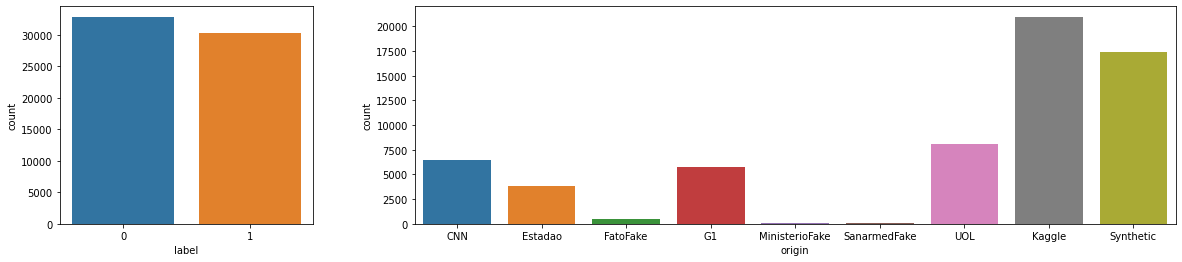

In [78]:
# Set grid of 2 columns
fig, (a0, a1) = plt.subplots(ncols=2, gridspec_kw = {'width_ratios':[1, 3]})
fig.set_figwidth(20)
# Show count for positive for fake news (1) and negative for fake news (0)
sns.countplot(x="label", data=data, ax=a0)
# Show count for every origin
sns.countplot(x="origin", data=data, ax=a1)
plt.show()

In [79]:
# Save pickle file with balanced dataframe
with open(r'pickles\balanced.pickle', 'wb') as f:
    pickle.dump(data, f)

In [3]:
# Load pickle file with balanced dataframe
with open(r'pickles\balanced.pickle', 'rb') as f:
    data = pickle.load(f)

### Representação vetorial (Tf-Idf)

In [4]:
# Split data into features (X) and label (y)
X_data = np.array(data['title'])
y_data = np.array(data['label'])

# Apply Tf-Idf representation
vectorizer = TfidfVectorizer()
X_data = vectorizer.fit_transform(X_data)

### Redução de Dimensionalidade (LSA - TruncatedSVD)

In [5]:
LSA = TruncatedSVD(n_components=30, n_iter=150, random_state=0)
X_data = LSA.fit_transform(X_data)
Sigma = LSA.singular_values_
V_T = LSA.components_.T

### Treinamento, teste e avaliação de alguns algoritmos

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [8]:
NB_classifier = GaussianNB()
y_pred = NB_classifier.fit(X_train, y_train).predict(X_test)
print("Naive Bayes score: ", NB_classifier.score(X_test, y_test))

print(classification_report(y_test, y_pred))

act = pd.Series(y_test, name='Actual')
prd = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(act, prd)
df_confusion

Naive Bayes score:  0.7014004272489912
              precision    recall  f1-score   support

           0       0.78      0.59      0.67      6493
           1       0.65      0.82      0.73      6146

    accuracy                           0.70     12639
   macro avg       0.72      0.70      0.70     12639
weighted avg       0.72      0.70      0.70     12639



Predicted,0,1
Actual,,
0,3808,2685
1,1089,5057


In [9]:
LR_classifier = LogisticRegression()
y_pred = LR_classifier.fit(X_train, y_train).predict(X_test)
print("Logistic Regression score: ", LR_classifier.score(X_test, y_test))

print(classification_report(y_test, y_pred))

act = pd.Series(y_test, name='Actual')
prd = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(act, prd)
df_confusion

Logistic Regression score:  0.7931798401772292
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      6493
           1       0.80      0.76      0.78      6146

    accuracy                           0.79     12639
   macro avg       0.79      0.79      0.79     12639
weighted avg       0.79      0.79      0.79     12639



Predicted,0,1
Actual,,
0,5327,1166
1,1448,4698


In [10]:
SVM_classifier = SVC(kernel='rbf')
y_pred = SVM_classifier.fit(X_train, y_train).predict(X_test)
print("Support Vector Machine score: ", SVM_classifier.score(X_test, y_test))

print(classification_report(y_test, y_pred))

act = pd.Series(y_test, name='Actual')
prd = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(act, prd)
df_confusion

Support Vector Machine score:  0.8411266714138776
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      6493
           1       0.84      0.84      0.84      6146

    accuracy                           0.84     12639
   macro avg       0.84      0.84      0.84     12639
weighted avg       0.84      0.84      0.84     12639



Predicted,0,1
Actual,,
0,5477,1016
1,992,5154


In [14]:
NN_classifier = MLPClassifier(hidden_layer_sizes=(30,30,15), activation='relu', solver='adam', max_iter=500)
y_pred = NN_classifier.fit(X_train, y_train).predict(X_test)
print("Neural Network score: ", NN_classifier.score(X_test, y_test))

print(classification_report(y_test, y_pred))

act = pd.Series(y_test, name='Actual')
prd = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(act, prd)
df_confusion

Neural Network score:  0.8533902998654956
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6493
           1       0.87      0.82      0.84      6146

    accuracy                           0.85     12639
   macro avg       0.85      0.85      0.85     12639
weighted avg       0.85      0.85      0.85     12639



Predicted,0,1
Actual,,
0,5750,743
1,1110,5036
